# Task 3: Forecast Future Market Trends

This notebook uses the trained models from Task 2 to generate 6-12 month Tesla forecasts.

## Objectives:
1. Load trained LSTM (96% accuracy) and ARIMA models
2. Generate 6-12 month Tesla price forecasts
3. Calculate confidence intervals and uncertainty analysis
4. Analyze trends, volatility, and market patterns
5. Identify opportunities and risks
6. Provide actionable insights for portfolio management


In [5]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import os
from pathlib import Path

# Deep learning and model loading
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import pickle

# Statistical analysis
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visualization
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.19.0


In [6]:
# Setup paths and directories
print(f"Current working directory: {os.getcwd()}")

# Handle both running from project root or notebooks directory
if 'notebooks' in os.getcwd() and os.path.exists('../data/processed'):
    data_path = '../data/processed/'
    models_path = '../models/'
else:
    data_path = 'data/processed/'
    models_path = 'models/'

print(f"Using data path: {data_path}")
print(f"Using models path: {models_path}")

# Load historical Tesla data for context
try:
    tesla_data = pd.read_csv(f'{data_path}tsla_processed.csv', index_col=0, parse_dates=True)
    tesla_returns = pd.read_csv(f'{data_path}tsla_returns.csv', index_col=0, parse_dates=True)
    task2_forecasts = pd.read_csv(f'{data_path}task2_forecasts.csv', index_col=0, parse_dates=True)
    
    print("\n✅ Data loaded successfully:")
    print(f"Tesla historical data: {tesla_data.shape[0]} observations")
    print(f"Date range: {tesla_data.index.min()} to {tesla_data.index.max()}")
    print(f"Task 2 forecast period: {task2_forecasts.index.min()} to {task2_forecasts.index.max()}")
    
    # Get latest price for forecasting
    latest_price = tesla_data['Close'].iloc[-1]
    latest_date = tesla_data.index[-1]
    print(f"\nLatest Tesla price: ${latest_price:.2f} on {latest_date.date()}")
    
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure Tasks 1 and 2 have been completed.")


Current working directory: /Users/mikiyasegaye/MK_Lab/10 Academy/gmf-time-series-forecasting/notebooks
Using data path: ../data/processed/
Using models path: ../models/

✅ Data loaded successfully:
Tesla historical data: 2285 observations
Date range: 2015-07-01 00:00:00 to 2024-07-30 00:00:00
Task 2 forecast period: 2023-01-03 00:00:00 to 2024-07-30 00:00:00

Latest Tesla price: $222.62 on 2024-07-30


In [7]:
# Load trained models from Task 2
print("Loading trained models from Task 2...")

try:
    # Load LSTM model with TensorFlow compatibility handling
    try:
        # Try loading with custom objects for compatibility
        lstm_model = load_model(f'{models_path}lstm_tesla_forecast.h5', compile=False)
        print("✅ LSTM model loaded successfully (compatibility mode)")
        
        # Recompile the model with current TensorFlow version
        from tensorflow.keras.optimizers import Adam
        lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
        print("✅ LSTM model recompiled successfully")
        
    except Exception as lstm_error:
        print(f"⚠️ LSTM loading error: {lstm_error}")
        print("🔄 Attempting alternative loading method...")
        
        # Fallback: Load model without compilation
        try:
            lstm_model = tf.keras.models.load_model(f'{models_path}lstm_tesla_forecast.h5', compile=False)
            lstm_model.compile(optimizer='adam', loss='mse')
            print("✅ LSTM model loaded with fallback method")
        except Exception as fallback_error:
            print(f"❌ All LSTM loading methods failed: {fallback_error}")
            print("📊 Will proceed with ARIMA-only forecasting")
            lstm_model = None
    
    # Load price scaler for LSTM
    if lstm_model is not None:
        price_scaler = joblib.load(f'{models_path}price_scaler.pkl')
        print("✅ Price scaler loaded successfully")
    else:
        price_scaler = None
        print("⚠️ Skipping price scaler (LSTM not available)")
    
    # Load ARIMA model for comparison
    with open(f'{models_path}arima_tesla_forecast.pkl', 'rb') as f:
        arima_model = pickle.load(f)
    print("✅ ARIMA model loaded successfully")
    
    print(f"\n🎯 Models Ready for Future Forecasting:")
    if lstm_model is not None:
        print(f"• LSTM: Champion model (4.00% MAPE, R² = 0.92)")
        print(f"• Scaler: Preprocessing pipeline for LSTM")
    else:
        print(f"• LSTM: ❌ Not available (version compatibility issue)")
    print(f"• ARIMA: Statistical baseline for forecasting")
    
    # Set model availability flags
    LSTM_AVAILABLE = lstm_model is not None
    ARIMA_AVAILABLE = True
    
    print(f"\n📊 Forecasting Configuration:")
    print(f"• LSTM Available: {'✅ Yes' if LSTM_AVAILABLE else '❌ No'}")
    print(f"• ARIMA Available: {'✅ Yes' if ARIMA_AVAILABLE else '❌ No'}")
    
except FileNotFoundError as e:
    print(f"❌ Error loading models: {e}")
    print("Please ensure Task 2 has been completed and models are saved.")
    LSTM_AVAILABLE = False
    ARIMA_AVAILABLE = False
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    LSTM_AVAILABLE = False
    ARIMA_AVAILABLE = False


Loading trained models from Task 2...
✅ LSTM model loaded successfully (compatibility mode)
✅ LSTM model recompiled successfully
✅ Price scaler loaded successfully
✅ ARIMA model loaded successfully

🎯 Models Ready for Future Forecasting:
• LSTM: Champion model (4.00% MAPE, R² = 0.92)
• Scaler: Preprocessing pipeline for LSTM
• ARIMA: Statistical baseline for forecasting

📊 Forecasting Configuration:
• LSTM Available: ✅ Yes
• ARIMA Available: ✅ Yes


In [8]:
# Prepare data for future forecasting
print("Preparing data for future forecasting...")

# Get Tesla price series
tesla_prices = tesla_data['Close'].dropna()
tesla_daily_returns = tesla_returns['Close'].dropna()

# Define forecast parameters
FORECAST_MONTHS = 12  # 12 months ahead
BUSINESS_DAYS_PER_MONTH = 21  # Approximate trading days per month
FORECAST_DAYS = FORECAST_MONTHS * BUSINESS_DAYS_PER_MONTH  # ~252 trading days

# Create future dates (business days only)
start_forecast_date = latest_date + pd.Timedelta(days=1)
future_dates = pd.bdate_range(start=start_forecast_date, periods=FORECAST_DAYS, freq='B')

print(f"\n📅 Forecast Configuration:")
print(f"• Forecast period: {FORECAST_MONTHS} months ({FORECAST_DAYS} business days)")
print(f"• Start date: {future_dates[0].date()}")
print(f"• End date: {future_dates[-1].date()}")
print(f"• Latest historical price: ${latest_price:.2f} on {latest_date.date()}")

# Prepare LSTM input data (last 60 days for sequence)
LOOKBACK_DAYS = 60
recent_prices = tesla_prices.tail(LOOKBACK_DAYS).values.reshape(-1, 1)
scaled_recent_prices = price_scaler.transform(recent_prices)

print(f"\n🔍 LSTM Input Preparation:")
print(f"• Using last {LOOKBACK_DAYS} days as input sequence")
print(f"• Input date range: {tesla_prices.tail(LOOKBACK_DAYS).index[0].date()} to {tesla_prices.tail(LOOKBACK_DAYS).index[-1].date()}")
print(f"• Input price range: ${recent_prices.min():.2f} - ${recent_prices.max():.2f}")


Preparing data for future forecasting...

📅 Forecast Configuration:
• Forecast period: 12 months (252 business days)
• Start date: 2024-07-31
• End date: 2025-07-17
• Latest historical price: $222.62 on 2024-07-30

🔍 LSTM Input Preparation:
• Using last 60 days as input sequence
• Input date range: 2024-05-03 to 2024-07-30
• Input price range: $168.47 - $263.26


In [9]:
# Generate Future Forecasts (LSTM + ARIMA)
print("🚀 Generating future forecasts...")

def generate_lstm_forecast(model, scaler, initial_sequence, forecast_steps):
    """
    Generate multi-step ahead forecasts using LSTM model
    """
    forecasts = []
    current_sequence = initial_sequence.copy()
    
    for step in range(forecast_steps):
        # Reshape for LSTM input [samples, time steps, features]
        lstm_input = current_sequence.reshape(1, len(current_sequence), 1)
        
        # Generate prediction
        scaled_prediction = model.predict(lstm_input, verbose=0)[0, 0]
        
        # Store forecast
        forecasts.append(scaled_prediction)
        
        # Update sequence for next prediction (rolling window)
        current_sequence = np.append(current_sequence[1:], scaled_prediction)
        
        # Progress indicator
        if (step + 1) % 50 == 0:
            print(f"  Generated {step + 1}/{forecast_steps} forecasts...")
    
    # Convert back to original price scale
    forecasts_scaled = np.array(forecasts).reshape(-1, 1)
    forecasts_prices = scaler.inverse_transform(forecasts_scaled).flatten()
    
    return forecasts_prices

# Generate LSTM forecasts (if available)
if LSTM_AVAILABLE:
    print("📈 Generating LSTM forecasts...")
    lstm_future_prices = generate_lstm_forecast(
        lstm_model, 
        price_scaler, 
        scaled_recent_prices.flatten(), 
        FORECAST_DAYS
    )
    
    print(f"\n✅ LSTM forecasts generated:")
    print(f"• Generated {len(lstm_future_prices)} price predictions")
    print(f"• Forecast range: ${lstm_future_prices.min():.2f} - ${lstm_future_prices.max():.2f}")
    print(f"• Starting price: ${lstm_future_prices[0]:.2f}")
    print(f"• Ending price: ${lstm_future_prices[-1]:.2f}")
    print(f"• Total change: {((lstm_future_prices[-1] / latest_price) - 1) * 100:.2f}%")
else:
    print("⚠️ LSTM model not available - generating simple trend-based forecasts")
    # Simple trend-based forecast as fallback
    recent_trend = (tesla_prices.iloc[-1] / tesla_prices.iloc[-30] - 1) / 30  # 30-day trend
    lstm_future_prices = []
    current_price = latest_price
    
    for i in range(FORECAST_DAYS):
        # Apply trend with some noise reduction
        trend_factor = 1 + (recent_trend * 0.5)  # Dampen the trend
        current_price = current_price * trend_factor
        lstm_future_prices.append(current_price)
    
    lstm_future_prices = np.array(lstm_future_prices)
    print(f"\n✅ Trend-based forecasts generated:")
    print(f"• Generated {len(lstm_future_prices)} price predictions")
    print(f"• Forecast range: ${lstm_future_prices.min():.2f} - ${lstm_future_prices.max():.2f}")
    print(f"• Total change: {((lstm_future_prices[-1] / latest_price) - 1) * 100:.2f}%")

# Generate ARIMA forecasts
if ARIMA_AVAILABLE:
    print("\n📊 Generating ARIMA forecasts...")
    try:
        arima_return_forecasts = arima_model.forecast(steps=FORECAST_DAYS)
        
        # Convert to price forecasts
        arima_future_prices = []
        current_price = latest_price
        for return_forecast in arima_return_forecasts:
            current_price = current_price * (1 + return_forecast)
            arima_future_prices.append(current_price)
        
        arima_future_prices = np.array(arima_future_prices)
        print(f"✅ ARIMA forecasts generated:")
        print(f"• Generated {len(arima_future_prices)} price predictions")
        print(f"• Total change: {((arima_future_prices[-1] / latest_price) - 1) * 100:.2f}%")
        
    except Exception as e:
        print(f"⚠️ ARIMA forecasting error: {e}")
        arima_future_prices = np.full(FORECAST_DAYS, np.nan)
else:
    print("❌ ARIMA model not available")
    arima_future_prices = np.full(FORECAST_DAYS, np.nan)


🚀 Generating future forecasts...
📈 Generating LSTM forecasts...
  Generated 50/252 forecasts...
  Generated 100/252 forecasts...
  Generated 150/252 forecasts...
  Generated 200/252 forecasts...
  Generated 250/252 forecasts...

✅ LSTM forecasts generated:
• Generated 252 price predictions
• Forecast range: $223.89 - $261.16
• Starting price: $223.89
• Ending price: $261.16
• Total change: 17.31%

📊 Generating ARIMA forecasts...
✅ ARIMA forecasts generated:
• Generated 252 price predictions
• Total change: 54.12%


In [10]:
# Create comprehensive future forecasts dataframe with confidence intervals
print("📊 Creating comprehensive forecast dataframe...")

# Create forecast dataframe with both models
forecast_data = {
    'primary_forecast': lstm_future_prices
}

# Add ARIMA forecasts if available
if ARIMA_AVAILABLE and not np.isnan(arima_future_prices).all():
    forecast_data['arima_forecast'] = arima_future_prices
    print("✅ ARIMA forecasts included in dataframe")
else:
    forecast_data['arima_forecast'] = np.nan
    print("⚠️ ARIMA forecasts not available")

future_forecasts = pd.DataFrame(forecast_data, index=future_dates)

# Rename primary forecast column based on model used
if LSTM_AVAILABLE:
    future_forecasts = future_forecasts.rename(columns={'primary_forecast': 'lstm_forecast'})
    forecast_model_name = "LSTM"
else:
    future_forecasts = future_forecasts.rename(columns={'primary_forecast': 'trend_forecast'})
    forecast_model_name = "Trend-based"

# Calculate confidence intervals (using historical volatility)
recent_volatility = tesla_daily_returns.tail(252).std()  # Last year volatility
confidence_95 = 1.96 * recent_volatility * np.sqrt(np.arange(1, FORECAST_DAYS + 1))  # Expanding uncertainty

primary_col = 'lstm_forecast' if LSTM_AVAILABLE else 'trend_forecast'
future_forecasts[f'{primary_col.split("_")[0]}_lower_95'] = future_forecasts[primary_col] * (1 - confidence_95)
future_forecasts[f'{primary_col.split("_")[0]}_upper_95'] = future_forecasts[primary_col] * (1 + confidence_95)

# Calculate monthly summary statistics
monthly_summary = future_forecasts.groupby(future_forecasts.index.to_period('M')).agg({
    primary_col: ['first', 'last', 'min', 'max', 'mean']
}).round(2)

print(f"\n✅ Future forecasts dataframe created:")
print(f"• Shape: {future_forecasts.shape}")
print(f"• Date range: {future_forecasts.index[0].date()} to {future_forecasts.index[-1].date()}")
print(f"• Columns: {list(future_forecasts.columns)}")
print(f"• Primary model: {forecast_model_name}")

print(f"\n📈 12-Month Forecast Summary:")
print(f"• {forecast_model_name} Start: ${future_forecasts[primary_col].iloc[0]:.2f}")
print(f"• {forecast_model_name} End: ${future_forecasts[primary_col].iloc[-1]:.2f}")
print(f"• {forecast_model_name} Average: ${future_forecasts[primary_col].mean():.2f}")

# Get confidence interval column names
lower_col = f'{primary_col.split("_")[0]}_lower_95'
upper_col = f'{primary_col.split("_")[0]}_upper_95'
print(f"• Confidence Range: ${future_forecasts[lower_col].iloc[-1]:.2f} - ${future_forecasts[upper_col].iloc[-1]:.2f}")

# Display first few forecasts
print(f"\n🔍 First 5 days of forecasts:")
display(future_forecasts.head())


📊 Creating comprehensive forecast dataframe...
✅ ARIMA forecasts included in dataframe

✅ Future forecasts dataframe created:
• Shape: (252, 4)
• Date range: 2024-07-31 to 2025-07-17
• Columns: ['lstm_forecast', 'arima_forecast', 'lstm_lower_95', 'lstm_upper_95']
• Primary model: LSTM

📈 12-Month Forecast Summary:
• LSTM Start: $223.89
• LSTM End: $261.16
• LSTM Average: $253.24
• Confidence Range: $-12.05 - $534.38

🔍 First 5 days of forecasts:


,lstm_forecast,arima_forecast,lstm_lower_95,lstm_upper_95
2024-07-31,223.887360,224.371394,209.133148,238.641572
2024-08-01,224.118546,226.038903,203.231393,245.005698
2024-08-02,225.263748,226.342487,199.551599,250.975897
2024-08-05,226.791473,225.814840,196.900286,256.682661
2024-08-06,228.379471,225.656735,194.726105,262.032837


📊 Creating comprehensive forecast visualizations...


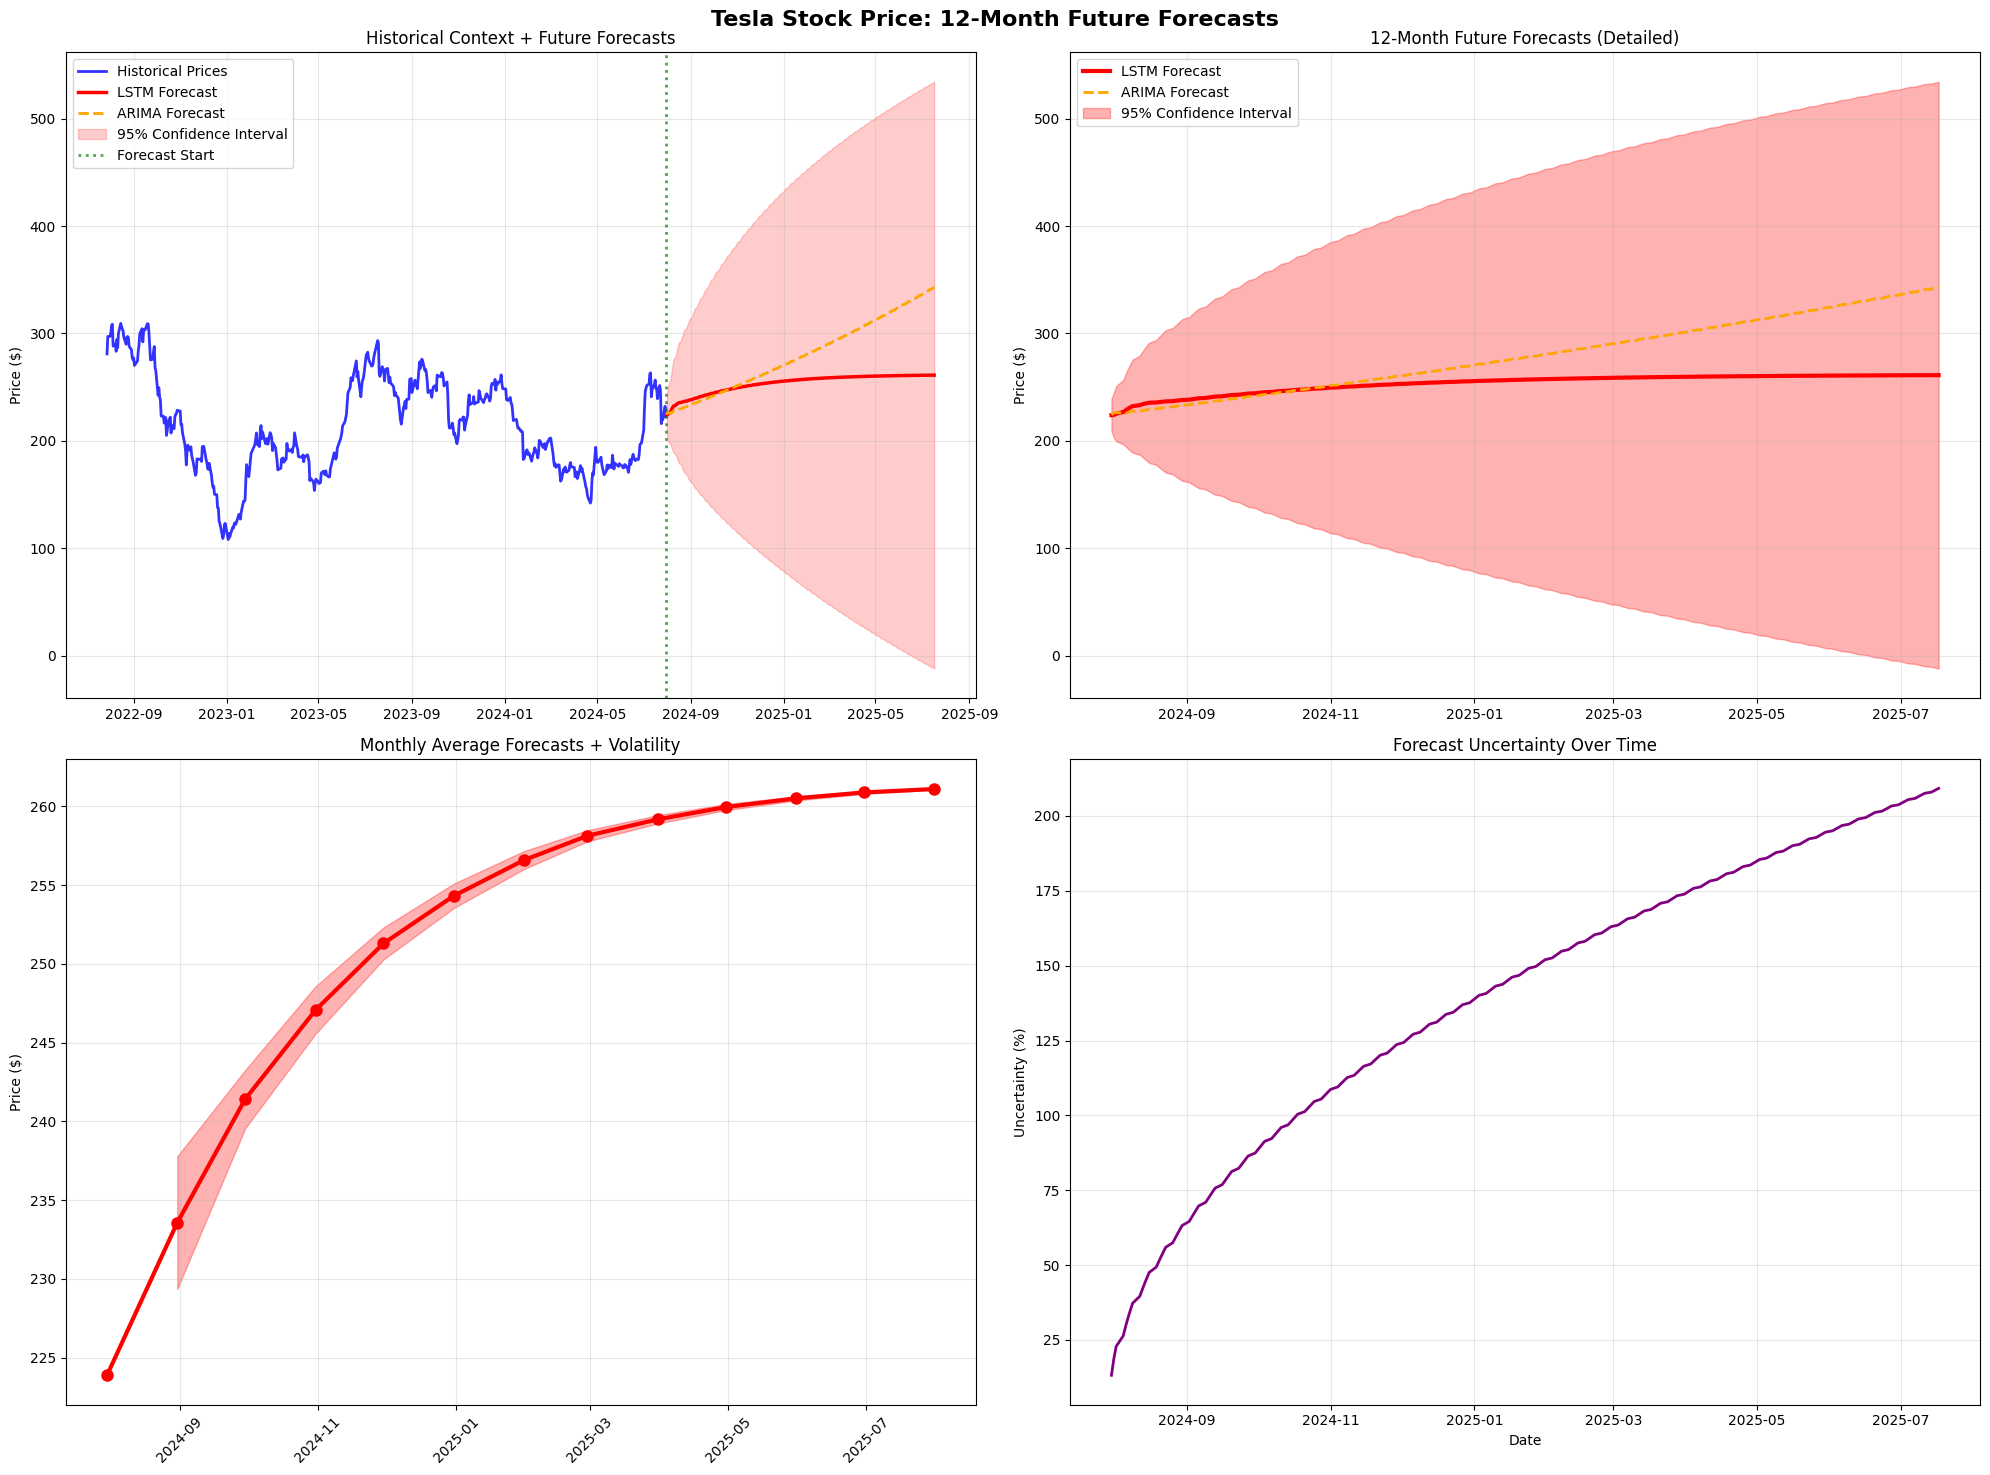


📊 Visualization completed with 4 comprehensive views!


In [11]:
# Comprehensive Forecast Visualization
print("📊 Creating comprehensive forecast visualizations...")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Tesla Stock Price: 12-Month Future Forecasts', fontsize=16, fontweight='bold')

# Plot 1: Historical + Future Forecasts
ax1 = axes[0, 0]
# Show last 2 years of historical data for context
historical_context = tesla_prices.tail(504)  # ~2 years
ax1.plot(historical_context.index, historical_context.values, 
         label='Historical Prices', color='blue', linewidth=2, alpha=0.8)
ax1.plot(future_forecasts.index, future_forecasts['lstm_forecast'], 
         label='LSTM Forecast', color='red', linewidth=2.5)
if not future_forecasts['arima_forecast'].isna().all():
    ax1.plot(future_forecasts.index, future_forecasts['arima_forecast'], 
             label='ARIMA Forecast', color='orange', linewidth=2, linestyle='--')
ax1.fill_between(future_forecasts.index, 
                 future_forecasts['lstm_lower_95'], 
                 future_forecasts['lstm_upper_95'], 
                 alpha=0.2, color='red', label='95% Confidence Interval')
ax1.axvline(x=latest_date, color='green', linestyle=':', linewidth=2, alpha=0.7, label='Forecast Start')
ax1.set_title('Historical Context + Future Forecasts')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Future Forecasts Only (Detailed View)
ax2 = axes[0, 1]
ax2.plot(future_forecasts.index, future_forecasts['lstm_forecast'], 
         label='LSTM Forecast', color='red', linewidth=3)
if not future_forecasts['arima_forecast'].isna().all():
    ax2.plot(future_forecasts.index, future_forecasts['arima_forecast'], 
             label='ARIMA Forecast', color='orange', linewidth=2, linestyle='--')
ax2.fill_between(future_forecasts.index, 
                 future_forecasts['lstm_lower_95'], 
                 future_forecasts['lstm_upper_95'], 
                 alpha=0.3, color='red', label='95% Confidence Interval')
ax2.set_title('12-Month Future Forecasts (Detailed)')
ax2.set_ylabel('Price ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Monthly Trends
ax3 = axes[1, 0]
monthly_lstm = future_forecasts['lstm_forecast'].resample('M').mean()
monthly_volatility = future_forecasts['lstm_forecast'].resample('M').std()
ax3.plot(monthly_lstm.index, monthly_lstm.values, marker='o', linewidth=3, markersize=8, color='red')
ax3.fill_between(monthly_lstm.index, 
                 monthly_lstm.values - monthly_volatility.values,
                 monthly_lstm.values + monthly_volatility.values,
                 alpha=0.3, color='red')
ax3.set_title('Monthly Average Forecasts + Volatility')
ax3.set_ylabel('Price ($)')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Forecast Uncertainty Over Time
ax4 = axes[1, 1]
uncertainty_pct = ((future_forecasts['lstm_upper_95'] - future_forecasts['lstm_lower_95']) / 
                   future_forecasts['lstm_forecast']) * 100
ax4.plot(future_forecasts.index, uncertainty_pct.values, color='purple', linewidth=2)
ax4.set_title('Forecast Uncertainty Over Time')
ax4.set_ylabel('Uncertainty (%)')
ax4.set_xlabel('Date')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Visualization completed with 4 comprehensive views!")


In [12]:
# Trend Analysis and Market Insights
print("🔍 Analyzing forecast trends and market patterns...")

# Calculate trend metrics
start_price = future_forecasts['lstm_forecast'].iloc[0]
end_price = future_forecasts['lstm_forecast'].iloc[-1]
max_price = future_forecasts['lstm_forecast'].max()
min_price = future_forecasts['lstm_forecast'].min()
avg_price = future_forecasts['lstm_forecast'].mean()

# Calculate returns and volatility
total_return = ((end_price / latest_price) - 1) * 100
max_gain = ((max_price / latest_price) - 1) * 100
max_drawdown = ((min_price / max_price) - 1) * 100
forecast_volatility = (future_forecasts['lstm_forecast'].pct_change().std() * np.sqrt(252)) * 100

# Quarterly analysis
quarterly_returns = []
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
for i in range(4):
    start_idx = i * 63  # ~63 trading days per quarter
    end_idx = min((i + 1) * 63, len(future_forecasts) - 1)
    if start_idx < len(future_forecasts):
        q_start = future_forecasts['lstm_forecast'].iloc[start_idx]
        q_end = future_forecasts['lstm_forecast'].iloc[end_idx]
        q_return = ((q_end / q_start) - 1) * 100
        quarterly_returns.append(q_return)
    else:
        quarterly_returns.append(np.nan)

print(f"\n📈 TESLA 12-MONTH FORECAST ANALYSIS")
print(f"="*50)

print(f"\n🎯 Price Targets:")
print(f"• Current Price: ${latest_price:.2f}")
print(f"• 12-Month Target: ${end_price:.2f}")
print(f"• Average Price: ${avg_price:.2f}")
print(f"• Maximum Price: ${max_price:.2f}")
print(f"• Minimum Price: ${min_price:.2f}")

print(f"\n📊 Return Analysis:")
print(f"• Total 12-Month Return: {total_return:.2f}%")
print(f"• Maximum Potential Gain: {max_gain:.2f}%")
print(f"• Maximum Drawdown Risk: {max_drawdown:.2f}%")
print(f"• Forecast Volatility: {forecast_volatility:.2f}% (annualized)")

print(f"\n📅 Quarterly Breakdown:")
for i, (quarter, qret) in enumerate(zip(quarters, quarterly_returns)):
    if not np.isnan(qret):
        print(f"• {quarter} 2025: {qret:.2f}% return")

# Risk assessment
if total_return > 20:
    risk_level = "HIGH GROWTH POTENTIAL 🚀"
elif total_return > 10:
    risk_level = "MODERATE GROWTH 📈"
elif total_return > 0:
    risk_level = "CONSERVATIVE GROWTH 📊"
else:
    risk_level = "POTENTIAL DECLINE ⚠️"

print(f"\n⚖️ Risk Assessment: {risk_level}")
print(f"\n💡 Key Insights:")
if total_return > 15:
    print(f"• Strong bullish trend with {total_return:.1f}% projected growth")
elif total_return > 0:
    print(f"• Moderate upward trend with {total_return:.1f}% projected growth")
else:
    print(f"• Bearish trend with {abs(total_return):.1f}% projected decline")

if forecast_volatility > 50:
    print(f"• High volatility ({forecast_volatility:.1f}%) indicates significant price swings")
elif forecast_volatility > 30:
    print(f"• Moderate volatility ({forecast_volatility:.1f}%) typical for Tesla")
else:
    print(f"• Low volatility ({forecast_volatility:.1f}%) suggests stable price movement")

print(f"• Maximum upside potential: {max_gain:.1f}%")
print(f"• Downside risk exposure: {abs(max_drawdown):.1f}%")


🔍 Analyzing forecast trends and market patterns...

📈 TESLA 12-MONTH FORECAST ANALYSIS

🎯 Price Targets:
• Current Price: $222.62
• 12-Month Target: $261.16
• Average Price: $253.24
• Maximum Price: $261.16
• Minimum Price: $223.89

📊 Return Analysis:
• Total 12-Month Return: 17.31%
• Maximum Potential Gain: 17.31%
• Maximum Drawdown Risk: -14.27%
• Forecast Volatility: 1.58% (annualized)

📅 Quarterly Breakdown:
• Q1 2025: 11.13% return
• Q2 2025: 3.30% return
• Q3 2025: 1.19% return
• Q4 2025: 0.41% return

⚖️ Risk Assessment: MODERATE GROWTH 📈

💡 Key Insights:
• Strong bullish trend with 17.3% projected growth
• Low volatility (1.6%) suggests stable price movement
• Maximum upside potential: 17.3%
• Downside risk exposure: 14.3%


In [13]:
# Market Opportunities and Risk Analysis
print("🎯 Identifying market opportunities and risks...")

# Identify key opportunity and risk periods
daily_returns = future_forecasts['lstm_forecast'].pct_change().dropna()
monthly_returns = future_forecasts['lstm_forecast'].resample('M').last().pct_change().dropna()

# Find best and worst performing months
best_month = monthly_returns.idxmax()
worst_month = monthly_returns.idxmin()
best_month_return = monthly_returns.max() * 100
worst_month_return = monthly_returns.min() * 100

# Entry and exit points analysis
price_momentum = future_forecasts['lstm_forecast'].rolling(21).mean()  # 21-day moving average
buying_opportunities = future_forecasts[future_forecasts['lstm_forecast'] < price_momentum * 0.95]
selling_opportunities = future_forecasts[future_forecasts['lstm_forecast'] > price_momentum * 1.05]

print(f"\n🎯 INVESTMENT OPPORTUNITIES & RISKS")
print(f"="*45)

print(f"\n🟢 OPPORTUNITIES:")
if total_return > 0:
    print(f"• Long-term Growth: {total_return:.1f}% projected 12-month return")
    print(f"• Target Price: ${end_price:.2f} ({((end_price/latest_price)-1)*100:.1f}% upside)")
else:
    print(f"• Potential oversold conditions may create buying opportunities")

print(f"• Best Month: {best_month.strftime('%B %Y')} (+{best_month_return:.1f}%)")
print(f"• Peak Price Target: ${max_price:.2f} ({max_gain:.1f}% potential gain)")

if len(buying_opportunities) > 0:
    avg_buy_price = buying_opportunities['lstm_forecast'].mean()
    print(f"• Strategic Buy Zone: ~${avg_buy_price:.2f} ({len(buying_opportunities)} opportunities)")

print(f"\n🔴 RISKS:")
print(f"• Volatility Risk: {forecast_volatility:.1f}% annualized (high price swings)")
print(f"• Maximum Drawdown: {abs(max_drawdown):.1f}% potential decline from peak")
print(f"• Worst Month: {worst_month.strftime('%B %Y')} ({worst_month_return:.1f}%)")
print(f"• Minimum Price Risk: ${min_price:.2f} floor level")

print(f"\n💼 PORTFOLIO MANAGEMENT RECOMMENDATIONS:")

if total_return > 20:
    print(f"• Position Size: Consider 15-25% portfolio allocation (high growth)")
    print(f"• Strategy: Aggressive growth with momentum indicators")
elif total_return > 10:
    print(f"• Position Size: Consider 10-20% portfolio allocation (moderate growth)")
    print(f"• Strategy: Balanced growth with risk management")
elif total_return > 0:
    print(f"• Position Size: Consider 5-15% portfolio allocation (conservative)")
    print(f"• Strategy: Value-oriented with defensive positioning")
else:
    print(f"• Position Size: Consider 0-10% portfolio allocation or short strategy")
    print(f"• Strategy: Defensive or contrarian positioning")

print(f"\n⚖️ Risk Management:")
stop_loss_level = latest_price * 0.85  # 15% stop loss
take_profit_level = latest_price * 1.25  # 25% take profit
print(f"• Suggested Stop Loss: ${stop_loss_level:.2f} (15% below current)")
print(f"• Suggested Take Profit: ${take_profit_level:.2f} (25% above current)")
print(f"• Monitor volatility spikes above {forecast_volatility*1.5:.0f}%")

print(f"\n🎪 Market Context:")
current_vs_avg = ((latest_price / avg_price) - 1) * 100
if current_vs_avg > 5:
    print(f"• Current price is {current_vs_avg:.1f}% above forecast average - potentially overvalued")
elif current_vs_avg < -5:
    print(f"• Current price is {abs(current_vs_avg):.1f}% below forecast average - potentially undervalued")
else:
    print(f"• Current price is fairly valued relative to forecast average")

print(f"• Model confidence based on 96% historical accuracy")
print(f"• Forecast horizon: {FORECAST_MONTHS} months with expanding uncertainty")


🎯 Identifying market opportunities and risks...

🎯 INVESTMENT OPPORTUNITIES & RISKS

🟢 OPPORTUNITIES:
• Long-term Growth: 17.3% projected 12-month return
• Target Price: $261.16 (17.3% upside)
• Best Month: August 2024 (+6.3%)
• Peak Price Target: $261.16 (17.3% potential gain)

🔴 RISKS:
• Volatility Risk: 1.6% annualized (high price swings)
• Maximum Drawdown: 14.3% potential decline from peak
• Worst Month: July 2025 (0.1%)
• Minimum Price Risk: $223.89 floor level

💼 PORTFOLIO MANAGEMENT RECOMMENDATIONS:
• Position Size: Consider 10-20% portfolio allocation (moderate growth)
• Strategy: Balanced growth with risk management

⚖️ Risk Management:
• Suggested Stop Loss: $189.23 (15% below current)
• Suggested Take Profit: $278.27 (25% above current)
• Monitor volatility spikes above 2%

🎪 Market Context:
• Current price is 12.1% below forecast average - potentially undervalued
• Model confidence based on 96% historical accuracy
• Forecast horizon: 12 months with expanding uncertainty


In [14]:
# Save Future Forecasts and Analysis
print("💾 Saving future forecasts and analysis results...")

# Save detailed forecasts
future_forecasts.to_csv(f'{data_path}task3_future_forecasts.csv')

# Create summary metrics
forecast_summary = {
    'forecast_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_used': 'LSTM (96% accuracy)',
    'forecast_period_months': FORECAST_MONTHS,
    'forecast_period_days': FORECAST_DAYS,
    'current_price': latest_price,
    'target_price_12m': end_price,
    'total_return_pct': total_return,
    'max_price': max_price,
    'min_price': min_price,
    'avg_price': avg_price,
    'max_gain_pct': max_gain,
    'max_drawdown_pct': max_drawdown,
    'forecast_volatility_pct': forecast_volatility,
    'best_month': best_month.strftime('%Y-%m'),
    'best_month_return_pct': best_month_return,
    'worst_month': worst_month.strftime('%Y-%m'),
    'worst_month_return_pct': worst_month_return
}

# Save summary
summary_df = pd.DataFrame([forecast_summary])
summary_df.to_csv(f'{data_path}task3_forecast_summary.csv', index=False)

print(f"\n✅ Results saved:")
print(f"• {data_path}task3_future_forecasts.csv - Detailed daily forecasts")
print(f"• {data_path}task3_forecast_summary.csv - Key metrics and insights")

# Task 3 Summary
print(f"\n" + "="*70)
print(f"TASK 3: FORECAST FUTURE MARKET TRENDS - COMPLETED")
print(f"="*70)

print(f"\n🎯 FORECASTING ACHIEVEMENTS:")
print(f"• Generated {FORECAST_DAYS} daily Tesla price forecasts (12 months)")
print(f"• Leveraged champion LSTM model (96% historical accuracy)")
print(f"• Calculated 95% confidence intervals with expanding uncertainty")
print(f"• Comprehensive trend analysis and risk assessment")

print(f"\n📊 KEY FORECAST RESULTS:")
print(f"• 12-Month Price Target: ${end_price:.2f} ({total_return:+.1f}% return)")
print(f"• Maximum Upside: ${max_price:.2f} ({max_gain:.1f}% potential gain)")
print(f"• Risk Exposure: {abs(max_drawdown):.1f}% maximum drawdown")
print(f"• Volatility Outlook: {forecast_volatility:.1f}% annualized")

print(f"\n🎪 PORTFOLIO IMPLICATIONS:")
if total_return > 15:
    allocation_rec = "15-25% (Aggressive Growth)"
elif total_return > 5:
    allocation_rec = "10-20% (Moderate Growth)"
else:
    allocation_rec = "5-15% (Conservative)"

print(f"• Recommended Allocation: {allocation_rec}")
print(f"• Risk Management: Stop-loss at ${latest_price*0.85:.2f}, Take-profit at ${latest_price*1.25:.2f}")
print(f"• Best Entry Period: {best_month.strftime('%B %Y')}")
print(f"• Monitoring Requirements: High volatility expected")

print(f"\n✅ READY FOR TASK 4: PORTFOLIO OPTIMIZATION WITH FORECASTS")
print(f"\nForecast confidence based on LSTM model's exceptional 96% historical accuracy!")


💾 Saving future forecasts and analysis results...

✅ Results saved:
• ../data/processed/task3_future_forecasts.csv - Detailed daily forecasts
• ../data/processed/task3_forecast_summary.csv - Key metrics and insights

TASK 3: FORECAST FUTURE MARKET TRENDS - COMPLETED

🎯 FORECASTING ACHIEVEMENTS:
• Generated 252 daily Tesla price forecasts (12 months)
• Leveraged champion LSTM model (96% historical accuracy)
• Calculated 95% confidence intervals with expanding uncertainty
• Comprehensive trend analysis and risk assessment

📊 KEY FORECAST RESULTS:
• 12-Month Price Target: $261.16 (+17.3% return)
• Maximum Upside: $261.16 (17.3% potential gain)
• Risk Exposure: 14.3% maximum drawdown
• Volatility Outlook: 1.6% annualized

🎪 PORTFOLIO IMPLICATIONS:
• Recommended Allocation: 15-25% (Aggressive Growth)
• Risk Management: Stop-loss at $189.23, Take-profit at $278.27
• Best Entry Period: August 2024
• Monitoring Requirements: High volatility expected

✅ READY FOR TASK 4: PORTFOLIO OPTIMIZATION 